In [1]:
import os
os.chdir('../scripts')
import pandas as pd
from analysis_tools_cython import import_lightcurve, processing

In [2]:
df = pd.read_csv('../candidates/272-candidates.csv')
data = df[df.tags == 'red'].reset_index(drop=True)

In [3]:
data.columns

Index(['path', 'TIC_ID', 'Sector', 'signal', 'snr', 'time', 'asym_score',
       'amplitude', 'width', 'skewness', 'skewness_err', 'duration', 'depth',
       'peak_lspower', 'mstat', 'm', 'n', 'chisq_gauss', 'chisq_skew',
       'rchisq_gauss', 'rchisq_skew', 'rmse_gauss', 'rmse_skew', 'mae_gauss',
       'mae_skew', 'transit_prob', 'abs_path', 'abs_depth', 'filepath',
       'Camera', 'Chip', 'RA', 'DEC', 'tic_id', 'GAIAmag', 'gaiabp', 'gaiarp',
       'd', 'e_d', 'plx', 'e_plx', 'Tmag', 'e_Tmag', 'Bmag', 'e_Bmag', 'Vmag',
       'lum', 'lumclass', 'Teff', 'tags'],
      dtype='object')

In [4]:
import lightkurve as lk
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np

In [5]:
#os.mkdir('../compare-plots')

In [7]:
#plt.plot(qlp_test.time.value,qlp_test.kspsap_flux)

  0%|          | 0/105 [00:02<?, ?it/s]


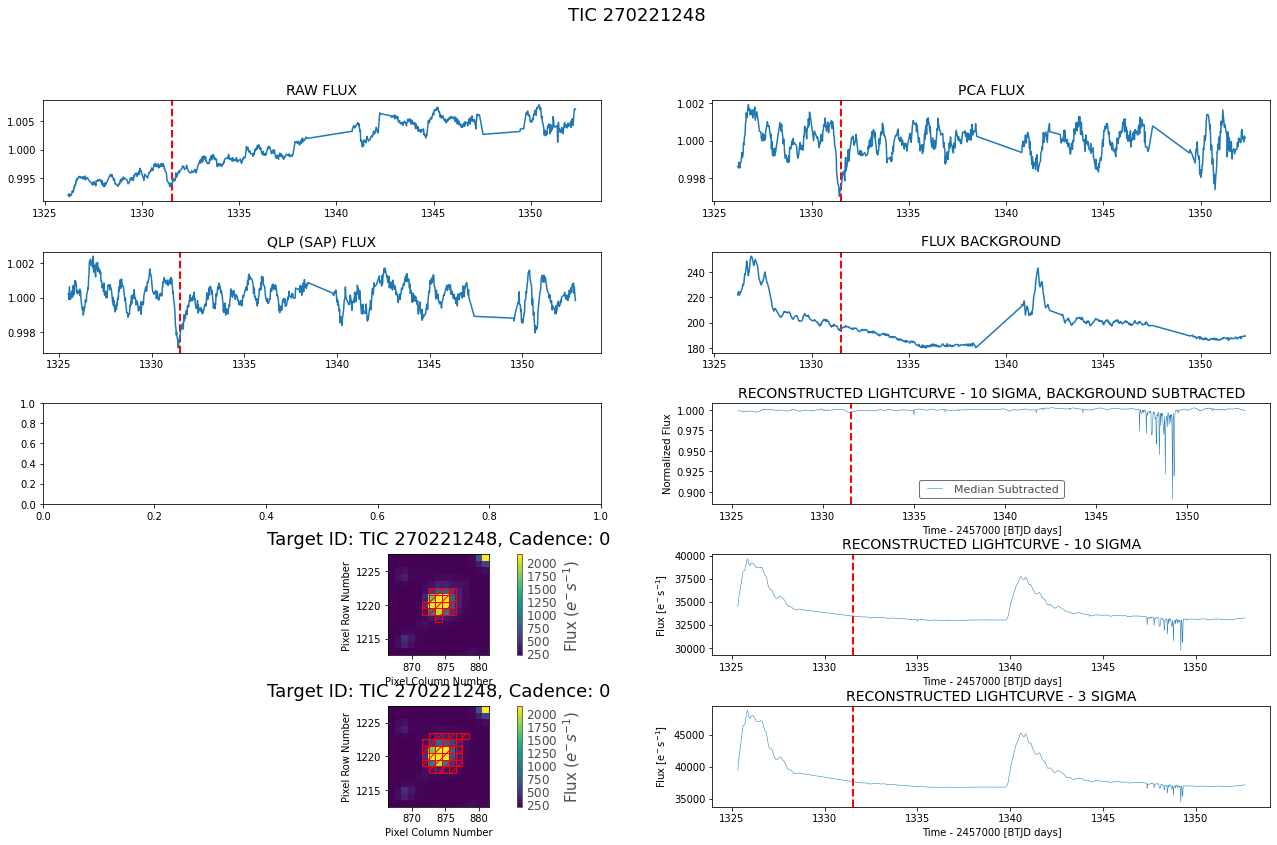

In [10]:
for i in tqdm(data.index):
    # try:
    filepath = data.iloc[i].abs_path
    lc, lc_info = import_lightcurve(filepath)

    tic_id = data.iloc[i].TIC_ID
    sector = data.iloc[i].Sector
    transit_time = data.iloc[i].time

    # Lightkurve TESS cutout
    tpf = lk.search_tesscut(f'TIC {tic_id}', sector=sector).download_all(cutout_size=(15, 15))
    
    ## higher sigma cut
    tpf = tpf[0]
    custom_mask = tpf.create_threshold_mask(threshold=10)
    lkcurve = tpf.to_lightcurve(aperture_mask=custom_mask)
    lkcurveq = lkcurve.quality == 0

    ## lower sigma cut
    #tpf2 = tpf[0]
    custom_mask2 = tpf.create_threshold_mask(threshold=3)
    lkcurve2 = tpf.to_lightcurve(aperture_mask=custom_mask2)
    lkcurveq2 = lkcurve2.quality == 0

    # Lightkurve QLP
    qlp = lk.search_lightcurve(f"TIC {tic_id}", sector=sector, author='QLP', exptime=1800)

    # SPOC
    spoc = lk.search_lightcurve(f"TIC {tic_id}", sector=sector, author='TESS-SPOC')
    
    # Check if any data products are available
    if len(qlp) == 0:
        qlp = None
    else:
        qlp = qlp.download()
        q = qlp.quality == 0

    if len(spoc) == 0:
        spoc = None
    else:
        spoc = spoc.download()
        qu = spoc.quality == 0

    # Plotting
    fig, axs = plt.subplots(5, 2, figsize=(22, 13))

    # Plotting the eleanor-lite ones
    axs[0, 0].plot(lc['TIME'], lc['RAW_FLUX'] / np.nanmedian(lc['RAW_FLUX']))
    axs[0, 0].axvline(transit_time, linestyle='--', linewidth=2, color='red', zorder=1)
    axs[0, 0].set_title('RAW FLUX', fontsize=14)

    axs[0, 1].plot(lc['TIME'], lc['PCA_FLUX'] / np.nanmedian(lc['PCA_FLUX']))
    axs[0, 1].axvline(transit_time, linestyle='--', linewidth=2, color='red', zorder=1)
    axs[0, 1].set_title('PCA FLUX', fontsize=14)

    # Check if QLP lightcurve exists
    if qlp:
        axs[1, 0].plot(qlp.time.value[q], qlp.flux[q]) # sap flux
        axs[1, 0].axvline(transit_time, linestyle='--', linewidth=2, color='red', zorder=1)
        axs[1, 0].set_title('QLP (SAP) FLUX', fontsize=14)

    axs[1, 1].plot(lc['TIME'], lc['FLUX_BKG'])
    axs[1, 1].axvline(transit_time, linestyle='--', linewidth=2, color='red', zorder=1)
    axs[1, 1].set_title('FLUX BACKGROUND', fontsize=14)


    if spoc:
        axs[2,0].plot(spoc.time.value[qu], spoc.pdcsap_flux[qu])
        axs[2, 0].axvline(transit_time, linestyle='--', linewidth=2, color='red', zorder=1)
        axs[2, 0].set_title('SPOC PDCSAP', fontsize=14)

    # Background subtracted
    regressors = tpf.flux[:, ~custom_mask]
    bkg = np.median(regressors, axis=1)
    bkg -= np.percentile(bkg, 5)

    npix = custom_mask.sum()
    median_subtracted_lc = lkcurve - npix * bkg
    median_subtracted_lc.plot(ax=axs[2,1], normalize=True, label="Median Subtracted")
    axs[2, 1].axvline(transit_time, linestyle='--', linewidth=2, color='red', zorder=1)
    axs[2,1].set_title('RECONSTRUCTED LIGHTCURVE - 10 SIGMA, BACKGROUND SUBTRACTED', fontsize=14)


    # Plot the TPF in the first subplot
    tpf.plot(ax=axs[3, 0], aperture_mask=custom_mask)
    lkcurve[lkcurveq].plot(ax=axs[3, 1])
    axs[3, 1].axvline(transit_time, linestyle='--', linewidth=2, color='red', zorder=1)
    axs[3, 1].set_title('RECONSTRUCTED LIGHTCURVE - 10 SIGMA', fontsize=14)

    # lower sigma cut TPF
    tpf.plot(ax=axs[4, 0], aperture_mask=custom_mask2)
    lkcurve2[lkcurveq2].plot(ax=axs[4, 1])
    axs[4, 1].axvline(transit_time, linestyle='--', linewidth=2, color='red', zorder=1)
    axs[4, 1].set_title('RECONSTRUCTED LIGHTCURVE - 3 SIGMA', fontsize=14)

    plt.subplots_adjust(hspace=0.5)
    fig.suptitle(f'TIC {tic_id}', fontsize=18)
    break

### eleanor

In [12]:
import eleanor

In [18]:
star = eleanor.Source(tic=tic_id,sector=int(sector))
target_data = eleanor.TargetData(star, height=15, width=15, bkg_size=31)
q = target_data.quality == 0

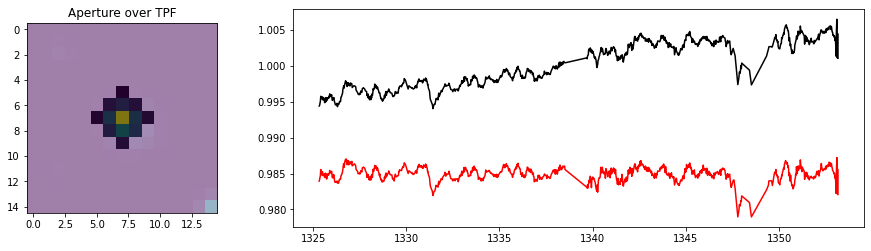

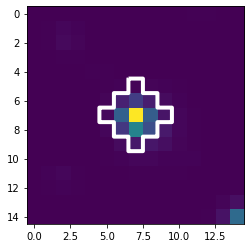

In [27]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15,4), gridspec_kw={'width_ratios':[1,3]})
ax1.imshow(target_data.tpf[0])
ax1.imshow(target_data.aperture, cmap='Greys', alpha=0.5)
ax1.set_title('Aperture over TPF')

ax2.plot(target_data.time[q], target_data.raw_flux[q]/np.nanmedian(target_data.raw_flux[q]), 'k', label='Raw')
ax2.plot(target_data.time[q], target_data.corr_flux[q]/np.nanmedian(target_data.corr_flux[q]) - 0.015, 'r', label='Corrected')

vis = eleanor.Visualize(target_data)
fig = vis.aperture_contour()

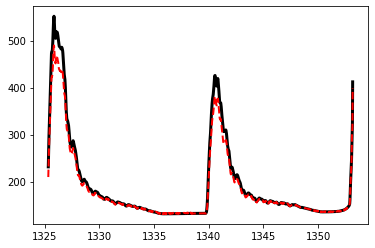

In [29]:
plt.plot(target_data.time[q], target_data.flux_bkg[q], 'k', label='1D postcard', linewidth=3)
plt.plot(target_data.time[q], target_data.tpf_flux_bkg[q], 'r--', label='1D TPF', linewidth=2)


---

### Beta Pic

#### TESSCut

In [19]:
tpf = lk.search_tesscut('TIC 270577175', sector=6).download_all(cutout_size=(15, 15))
tpf = tpf[0]
custom_mask = tpf[0].create_threshold_mask(threshold=15)
lkcurve = tpf.to_lightcurve(aperture_mask=custom_mask)

#### QLP

In [20]:
qlp = lk.search_lightcurve("TIC 270577175", sector=6, author='QLP', exptime=1800).download()

Text(0.5, 1.0, 'QLP SAP FLUX')

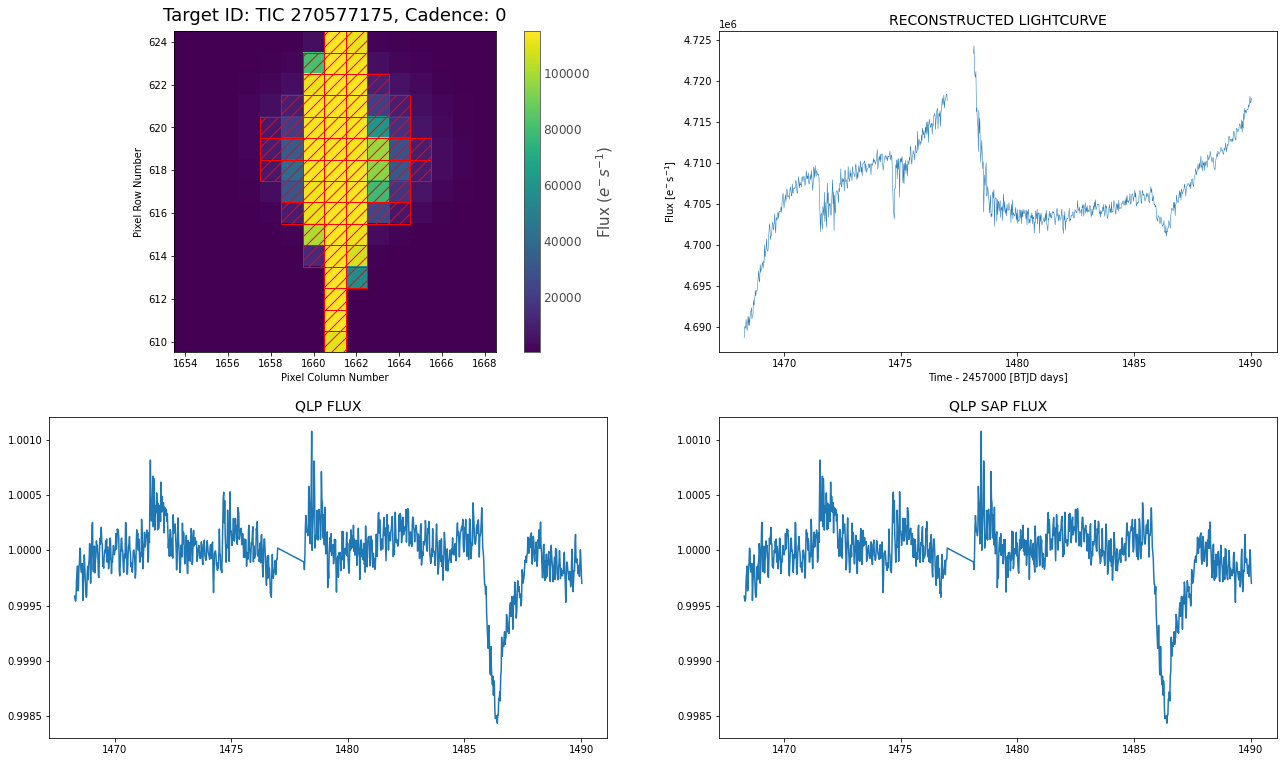

In [23]:
fig, axs = plt.subplots(2, 2, figsize=(22, 13))

# Plot the TPF in the first subplot
tpf.plot(ax=axs[0, 0], aperture_mask=custom_mask)
lkcurve.plot(ax=axs[0, 1])
axs[0, 1].set_title('RECONSTRUCTED LIGHTCURVE', fontsize=14)

# Check if QLP lightcurve exists
axs[1, 0].plot(qlp.time.value, qlp.flux)
axs[1, 0].set_title('QLP FLUX', fontsize=14)

axs[1, 1].plot(qlp.time.value, qlp.sap_flux)
axs[1, 1].set_title('QLP SAP FLUX', fontsize=14)


## Finding Spectral Types

In [9]:
from astroquery.simbad import Simbad
import pandas as pd

custom_simbad = Simbad()
custom_simbad.add_votable_fields('sptype')

def get_spectral_type(tic_id):
    try:
        tic = "TIC " + str(tic_id)
        result = custom_simbad.query_object(tic)
        sptype = result['SP_TYPE'][0] if 'SP_TYPE' in result else None
        main_id = result['MAIN_ID'][0]
        return sptype, main_id
    except Exception as e:
        print(f"Error querying TIC {tic_id}: {e}")
        return None, None  # Return a tuple with two None values in case of an error

# Apply the function and unpack the tuple into two columns
data[['sptype', 'star_name']] = data['TIC_ID'].apply(lambda ticid: pd.Series(get_spectral_type(ticid)))
data.head()

Error querying TIC 321009372: argument of type 'NoneType' is not iterable
Error querying TIC 320953684: argument of type 'NoneType' is not iterable
Error querying TIC 43360100: argument of type 'NoneType' is not iterable
Error querying TIC 131422529: argument of type 'NoneType' is not iterable
Error querying TIC 80551703: argument of type 'NoneType' is not iterable
Error querying TIC 143152957: argument of type 'NoneType' is not iterable
Error querying TIC 354676567: argument of type 'NoneType' is not iterable
Error querying TIC 373913825: argument of type 'NoneType' is not iterable
Error querying TIC 110969638: argument of type 'NoneType' is not iterable
Error querying TIC 64953602: argument of type 'NoneType' is not iterable
Error querying TIC 145276049: argument of type 'NoneType' is not iterable
Error querying TIC 110610421: argument of type 'NoneType' is not iterable
Error querying TIC 114485654: argument of type 'NoneType' is not iterable
Error querying TIC 349766841: argument of

,path,TIC_ID,Sector,signal,snr,time,asym_score,amplitude,width,skewness,...,e_Tmag,Bmag,e_Bmag,Vmag,lum,lumclass,Teff,tags,sptype,star_name
1,/tmp/eleanor-lite/s0001/hlsp_gsfc-eleanor-lite...,270221248,1,-14.56740,-5.11074,1331.51650,1.20205,0.00150,0.34304,4.02723,...,0.0071,11.499,0.090,10.324,0.009,GIANT,4549.9,red,None,CD-26 15932
4,/tmp/eleanor-lite/s0001/hlsp_gsfc-eleanor-lite...,321009372,1,-12.65549,-5.52199,1331.89123,1.03179,0.00265,0.44053,3.90642,...,0.0060,13.508,0.010,13.088,0.092,DWARF,6209.0,red,None,None
8,/tmp/eleanor-lite/s0001/hlsp_gsfc-eleanor-lite...,320953684,1,-11.52684,-5.58530,1331.91211,1.09684,0.00162,0.63095,4.58165,...,0.0060,13.351,0.029,12.437,0.080,GIANT,4828.0,red,None,None
22,/tmp/eleanor-lite/s0002/hlsp_gsfc-eleanor-lite...,313933211,2,-17.03498,-5.68182,1372.18299,1.04365,0.00216,0.30563,2.51171,...,0.0066,11.699,0.097,10.491,0.011,GIANT,4339.8,red,None,TYC 6412-610-1
23,/tmp/eleanor-lite/s0002/hlsp_gsfc-eleanor-lite...,66466482,2,-16.47490,-5.15932,1371.09987,1.07715,0.00207,0.46953,4.26592,...,0.0088,9.906,0.049,9.550,0.030,DWARF,6863.0,red,None,HD 222507


In [10]:
data[data['sptype'].notna()]

,path,TIC_ID,Sector,signal,snr,time,asym_score,amplitude,width,skewness,...,e_Tmag,Bmag,e_Bmag,Vmag,lum,lumclass,Teff,tags,sptype,star_name


In [142]:
data.sptype.unique()

array([None, '', 'F0V', 'B2Ia', 'G8II-III', 'A2', 'K0', 'G8/K0III',
       'G9III', 'B8III', 'F5', 'F0', 'G5', 'F', 'F2', 'A6V'], dtype=object)

In [128]:
custom_simbad = Simbad()
custom_simbad.add_votable_fields('sptype')
tic = "TIC " + str(270577175)
result = custom_simbad.query_object(tic)

In [132]:
result['SP_TYPE'][0] if 'SP_TYPE' in result else None

## RA DEC of Candidates

In [ ]:
ra = data['RA'].values * u.degree
dec = data['DEC'].values * u.degree

# Convert RA and DEC to SkyCoord object
sky_coords = SkyCoord(ra=ra, dec=dec, frame='icrs')

# Wrap RA values at 180 degrees
wrapped_coords = SkyCoord(ra=sky_coords.ra.wrap_at(180 * u.deg), dec=sky_coords.dec, frame='icrs')

# Create a scatter plot with Mollweide projection
plt.figure(figsize=(10, 6))
plt.subplot(111, projection="mollweide")
plt.scatter(sky_coords.ra.wrap_at('180d').radian, sky_coords.dec.radian, s=40, linewidth=0.5, marker='o', label='Exocomet Candidates')
plt.xlabel('RA')
plt.ylabel('DEC')

# Add grid in Mollweide projection
plt.savefig('../figs/RA-DEC.png',dpi=300,bbox_inches=None)
plt.grid(True)